# 1. Load config and variables

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import os

import spacy, pickle

import torch

from torchtext import data
from torchtext import datasets

import random
import inspect

# Custom impport
from common.common_classes import TensorField

In [3]:
torch.cuda.is_available()

True

In [4]:
path = "./"
save_data_path = path + 'save_data/'
large_save_data_path = '/notebooks/large-storage/'
saved_models_path = '/notebooks/large-storage/saved-models/'
print(os.listdir(path))

['test.tsv', 'GRU-with-attention-implement.ipynb', 'LSTM-with-attention-implement.ipynb', 'prepare-word-embedding-nlp.ipynb', 'LSTM-with-attention-use-pytorch-embedding-implement.ipynb', 'tokenization.ipynb', 'test-batching-padding.ipynb', 'train.tsv', 'test-batching-padding-ok.ipynb', 'LSTM-implement.ipynb', 'sampleSubmission.csv', 'save_data', '.ipynb_checkpoints', '__init__.py', 'README.md', 'generate-result-for-report.ipynb', '.gitignore', '.git', 'common', 'simple-GRU-implement.ipynb']


In [5]:
loaded_data = pickle.load(open(save_data_path + 'pre-processed-data.pkl', 'rb'))
loaded_kaggle_test = pickle.load(open(save_data_path + 'pre-processed-kaggle-test.pkl', 'rb'))
loaded_vocab = pickle.load(open(save_data_path + 'genereated-vocab.pkl', 'rb'))

In [6]:
loaded_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,Phrase_length,Tokenized_phrase,Indexed_phrase
0,1,1,A series of escapades demonstrating the adage ...,1,188,"[xxbos, a, series, of, escapades, demonstratin...","[2, 10, 341, 11, 14246, 6044, 8, 6604, 19, 64,..."
1,2,1,A series of escapades demonstrating the adage ...,2,77,"[xxbos, a, series, of, escapades, demonstratin...","[2, 10, 341, 11, 14246, 6044, 8, 6604, 19, 64,..."
2,3,1,A series,2,8,"[xxbos, a, series, xxeos]","[2, 10, 341, 3]"
3,4,1,A,2,1,"[xxbos, a, xxeos]","[2, 10, 3]"
4,5,1,series,2,6,"[xxbos, series, xxeos]","[2, 341, 3]"


In [7]:
loaded_kaggle_test.head()

,PhraseId,SentenceId,Phrase,Phrase_length,Tokenized_phrase,Indexed_phrase
0,156061,8545,An intermittently pleasing but mostly routine ...,188,"[xxbos, xxmaj, an, intermittently, pleasing, b...","[2, 7, 26, 2606, 1723, 30, 632, 1041, 409, 15, 3]"
1,156062,8545,An intermittently pleasing but mostly routine ...,77,"[xxbos, xxmaj, an, intermittently, pleasing, b...","[2, 7, 26, 2606, 1723, 30, 632, 1041, 409, 3]"
2,156063,8545,An,8,"[xxbos, xxmaj, an, xxeos]","[2, 7, 26, 3]"
3,156064,8545,intermittently pleasing but mostly routine effort,1,"[xxbos, intermittently, pleasing, but, mostly,...","[2, 2606, 1723, 30, 632, 1041, 409, 3]"
4,156065,8545,intermittently pleasing but mostly routine,6,"[xxbos, intermittently, pleasing, but, mostly,...","[2, 2606, 1723, 30, 632, 1041, 3]"


In [8]:
UNK, PAD, BOS, EOS, TK_REP, TK_WREP, TK_UP, TK_MAJ = "xxunk xxpad xxbos xxeos xxrep xxwrep xxup xxmaj".split()

default_spec_tok = [UNK, PAD, BOS, EOS, TK_REP, TK_WREP, TK_UP, TK_MAJ]

MAX_LABEL = 5

### Check max length of sequences

In [9]:
max_len = 0
max_index = -1
for i in range(len(loaded_data['Tokenized_phrase'])):
    if len(loaded_data['Tokenized_phrase'][i]) > max_len:
        max_len = len(loaded_data['Tokenized_phrase'][i])
        max_index = i
        
print(max_len)
print(max_index)

62
43802


In [10]:
max_len = 0
max_index = -1
for i in range(len(loaded_kaggle_test['Tokenized_phrase'])):
    if len(loaded_kaggle_test['Tokenized_phrase'][i]) > max_len:
        max_len = len(loaded_kaggle_test['Tokenized_phrase'][i])
        max_index = i
        
print(max_len)
print(max_index)

60
35146


# 2. Encoding and prepraing batches

In [11]:
nlp = spacy.load(large_save_data_path + 'process-spacy-model')

In [12]:
nlp.vocab[BOS].vector

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [13]:
type(nlp.vocab.get_vector('test'))

numpy.ndarray

In [14]:
nlp.vocab.vectors.data.shape

(890280, 308)

In [15]:
nlp.vocab.vectors.data.dtype

dtype('float32')

### Test assigning pytorch embedding with spacy

In [16]:
import torch.nn as nn

embed_weights = torch.tensor(nlp.vocab.vectors.data, dtype=torch.float32)
embed_layer = nn.Embedding.from_pretrained(embed_weights, freeze=True)

In [17]:
nlp.vocab.vectors.data.shape[1]

308

In [18]:
cat_id = nlp.vocab.strings[u'cat']
print(f"ID: {cat_id}")
cat_row = nlp.vocab.vectors.key2row[cat_id]
print(f"row: {cat_row}")

ID: 5439657043933447811
row: 1081


In [19]:
# cat_embedding is a Tensor representation of cat_vector
cat_vector = nlp.vocab.vectors[cat_id]
print(f"vector: {cat_vector}")
cat_embedding = embed_layer(torch.LongTensor([cat_row]))
print(f"embedding: {cat_embedding}")

vector: [-0.15067   -0.024468  -0.23368   -0.23378   -0.18382    0.32711
 -0.22084   -0.28777    0.12759    1.1656    -0.64163   -0.098455
 -0.62397    0.010431  -0.25653    0.31799    0.037779   1.1904
 -0.17714   -0.2595    -0.31461    0.038825  -0.15713   -0.13484
  0.36936   -0.30562   -0.40619   -0.38965    0.3686     0.013963
 -0.6895     0.004066  -0.1367     0.32564    0.24688   -0.14011
  0.53889   -0.80441   -0.1777    -0.12922    0.16303    0.14917
 -0.068429  -0.33922    0.18495   -0.082544  -0.46892    0.39581
 -0.13742   -0.35132    0.22223   -0.144     -0.048287   0.3379
 -0.31916    0.20526    0.098624  -0.23877    0.045338   0.43941
  0.030385  -0.013821  -0.093273  -0.18178    0.19438   -0.3782
  0.70144    0.16236    0.0059111  0.024898  -0.13613   -0.11425
 -0.31598   -0.14209    0.028194   0.5419    -0.42413   -0.599
  0.24976   -0.27003    0.14964    0.29287   -0.31281    0.16543
 -0.21045   -0.4408     1.2174     0.51236    0.56209    0.14131
  0.092514   0.71396

In [20]:
cat_embedding.dtype

torch.float32

In [21]:
embed_layer.weight.data.shape

torch.Size([890280, 308])

### Preprocessing

In [22]:
pad_id = nlp.vocab.strings[PAD]
print(f"ID: {pad_id}")
pad_row = nlp.vocab.vectors.key2row[pad_id]
print(f"row: {pad_row}")

ID: 15321870174910142188
row: 684831


In [23]:
# For Kaggle Train dataset
PHRASE_ID = data.Field(use_vocab = False)
TEXT = TensorField(include_lengths = True, use_vocab = False, sequential = False, pad_token = pad_row)
LABEL = data.LabelField(use_vocab = False, dtype=torch.long)

# For Kaggle Test dataset
ID_TEST = data.Field(use_vocab = False)
PHRASE_ID_TEST = data.Field(use_vocab = False)
TEXT_TEST = TensorField(include_lengths = True, use_vocab = False, sequential = False, pad_token = pad_row)

In [24]:
# For Kaggle Train dataset
fields = [('id', PHRASE_ID), ('text', TEXT), ('label', LABEL)]

# For Kaggle Test dataset
fields_test = [('id', ID_TEST), ('phrase_id', PHRASE_ID_TEST), ('text', TEXT_TEST)]

In [25]:
len(loaded_data['Phrase'])

156060

In [26]:
len(loaded_kaggle_test['Phrase'])

66292

In [27]:
# Get unknown row
unknown_id = nlp.vocab.strings[UNK]
unknown_row = nlp.vocab.vectors.key2row[unknown_id]
print(f"unknown_rown: {unknown_row}")

# For Kaggle Train dataset
examples = []
length = len(loaded_data['Phrase'])
for i in range(length):
    indexes = []
    for j in range(len(loaded_data['Tokenized_phrase'][i])):
        if nlp.vocab.has_vector(loaded_data['Tokenized_phrase'][i][j]):
            token_id = nlp.vocab.strings[loaded_data['Tokenized_phrase'][i][j]]
            token_row = nlp.vocab.vectors.key2row[token_id]

            indexes.append(token_row)
        else:
            indexes.append(unknown_row)
    
    examples.append(data.Example.fromlist([ [loaded_data['PhraseId'][i]], indexes, loaded_data['Sentiment'][i]], fields))
    
examples[:10]

unknown_rown: 0


In [28]:
# Get unknown row
unknown_id = nlp.vocab.strings[UNK]
unknown_row = nlp.vocab.vectors.key2row[unknown_id]
print(f"unknown_rown: {unknown_row}")

# For Kaggle Test dataset
examples_test = []
length = len(loaded_kaggle_test['Phrase'])
for i in range(length):
    indexes = []
    for j in range(len(loaded_kaggle_test['Tokenized_phrase'][i])):
        if nlp.vocab.has_vector(loaded_kaggle_test['Tokenized_phrase'][i][j]):
            token_id = nlp.vocab.strings[loaded_kaggle_test['Tokenized_phrase'][i][j]]
            token_row = nlp.vocab.vectors.key2row[token_id]
            
            indexes.append(token_row)
        else:
            indexes.append(unknown_row)
    
    examples_test.append(data.Example.fromlist([ [i], [loaded_kaggle_test['PhraseId'][i]], indexes ], fields_test))
    
examples_test[:10]

unknown_rown: 0


In [29]:
len(examples)

156060

In [30]:
len(examples_test)

66292

In [31]:
examples[3].text

[684832, 6, 684833]

In [32]:
# test extracted data
token_id = nlp.vocab.strings[EOS]
token_row = nlp.vocab.vectors.key2row[token_id]
print(f"token_rown: {token_row}")

token_rown: 684833


In [33]:
examples_test[3].text

[684832, 40929, 11176, 29, 737, 3812, 1240, 684833]

In [34]:
# test extracted data
token_id = nlp.vocab.strings['mostly']
token_row = nlp.vocab.vectors.key2row[token_id]
print(f"token_rown: {token_row}")

token_rown: 737


In [35]:
examples[3].label

2

In [36]:
data_set = data.Dataset(examples, fields)
data_set_test = data.Dataset(examples_test, fields_test)

In [37]:
data_set.sort_key = lambda x: len(x.text)
data_set_test.sort_key = lambda x: len(x.text)

In [38]:
SEED = 9131

In [39]:
train_data, valid_data, test_data = data_set.split([0.8, 0.1, 0.1], random_state = random.seed(SEED))

In [40]:
train_data.sort_key

<function __main__.<lambda>(x)>

In [41]:
len(data_set)*0.1

15606.0

In [42]:
len(train_data)

124848

In [43]:
len(valid_data)

15606

In [44]:
len(test_data)

15606

In [45]:
len(data_set_test)

66292

In [46]:
inspect.getsource(train_data.sort_key)

'data_set.sort_key = lambda x: len(x.text)\n'

In [47]:
inspect.getsource(data_set_test.sort_key)

'data_set_test.sort_key = lambda x: len(x.text)\n'

## Define Hyperparameter

In [48]:
BATCH_SIZE = 64

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

kaggle_test_iterator = data.BucketIterator(
    data_set_test, 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [50]:
raw_train_iterator = iter(train_iterator)
batch = next(raw_train_iterator)

raw_kaggle_test_iterator = iter(kaggle_test_iterator)
batch_test = next(raw_kaggle_test_iterator)

In [51]:
a, b = batch.text

c, d = batch_test.text

In [52]:
b

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')

In [53]:
a.shape

torch.Size([64, 9])

In [54]:
a

tensor([[684832,    200,     63,     90,      6, 333750,      8,  87261, 684833],
        [684832,      6,    176,     42,    313,   2358,   4023,   1214, 684833],
        [684832,      3,    141,    253,      6,   1889,    498,      2, 684833],
        [684832,    205,     56,     45,    181,   2593,   5716,  10983, 684833],
        [684832,    622,    891,     13,      3,     99,      2,   1864, 684833],
        [684832,     40,      2,    631,    354,      2,  16439,    810, 684833],
        [684832,      5,     23,      6, 684837,    186, 684837,  78888, 684833],
        [684832,    308,    407,   2325,      3,   2105,      8,   3242, 684833],
        [684832,   3868,    362,    495,    169,      3,    226,  33789, 684833],
        [684832,   4407,     13,     58,  12745,    239,      8,  12965, 684833],
        [684832,  12657,     13,     36,     94,   2996,     36,  60409, 684833],
        [684832,     13,   1321,    495,     29,    371,      3,   2181, 684833],
        [684832,

In [55]:
batch.label

tensor([2, 2, 0, 2, 2, 1, 3, 3, 1, 3, 3, 2, 2, 2, 2, 2, 0, 2, 1, 4, 3, 2, 3, 2,
        2, 2, 1, 3, 1, 2, 2, 1, 3, 1, 2, 2, 1, 4, 2, 3, 2, 3, 2, 2, 1, 4, 2, 2,
        2, 3, 2, 3, 1, 2, 2, 3, 4, 2, 2, 4, 2, 2, 1, 4], device='cuda:0')

In [56]:
batch.id

tensor([[133918,  57783,  94049,  86671,  84086,  74128, 112683, 126943,  12599,
         138419,  47937,  62635, 104584,  86587, 113162,  81036,  62472, 147974,
          32209, 133654,  95241, 137072,  66415,  75555,  53039, 130485,  79837,
         152257,  39951, 136680, 121126, 102615, 101662, 119728, 108929, 145776,
          36689,  66928, 109732, 109843, 130506,  33026, 123268, 155495, 114095,
          27453, 122599,  82520,  21535, 104973,  91096,  97182,  84542, 119081,
         104435,  65401,  30863, 141808,  39997, 145932,  46149, 125167, 132902,
         117864]], device='cuda:0')

In [57]:
loaded_data['Sentiment'][17921-1]

2

In [58]:
d

tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10], device='cuda:0')

In [59]:
c.shape

torch.Size([64, 10])

In [60]:
c

tensor([[684832,    858,     37,     10,     14,    117,      5,     23,    191,
         684833],
        [684832, 684837,     16, 684837, 146405, 684837,  11721,     92,      1,
         684833],
        [684832,     19,     16,      3,    420,  20523,      8,     85,    711,
         684833],
        [684832, 130283,      9,     78,    418,    154,     10,     14,   4905,
         684833],
        [684832, 684837,   4628,     76,      6,    127,      5, 298172,      2,
         684833],
        [684832,     36,    194,     63,     90,  12832,     13,      6,  24748,
         684833],
        [684832,   4089,   5529,      7,    588,     33,  34423,   4043,   2809,
         684833],
        [684832,    171,    227,  43211,      2,  97814,     33,  98296,  15611,
         684833],
        [684832,      8, 684837,   7078,    213,  36288,     24,    334,     99,
         684833],
        [684832,  38669,  13120,      8,     51,   8953,     33,   2467,  58039,
         684833],
        [6

In [61]:
batch_test.id.shape

torch.Size([1, 64])

In [62]:
batch_test.id

tensor([[47179, 50045, 46462, 44533, 53032, 32955, 11623, 20504, 41241,  8410,
          1622,  7377, 56392, 57556, 12486, 25215, 48991,  3850, 42415, 49212,
         59154,  2684, 52932, 62381, 26115, 65211, 63658, 28986, 15879, 58026,
         27986, 41181, 46849, 18459, 54574, 46478, 58239, 14695, 30341, 25839,
         59208, 35617, 58876, 56748, 17563, 58062,  6787, 22929, 23357, 17287,
          4608, 27127, 53929, 65272, 51887, 37848,  3149, 32164, 43127, 23021,
         64075, 26385, 32284, 37401]], device='cuda:0')

In [63]:
batch_test.phrase_id.shape

torch.Size([1, 64])

In [64]:
batch_test.phrase_id

tensor([[203240, 206106, 202523, 200594, 209093, 189016, 167684, 176565, 197302,
         164471, 157683, 163438, 212453, 213617, 168547, 181276, 205052, 159911,
         198476, 205273, 215215, 158745, 208993, 218442, 182176, 221272, 219719,
         185047, 171940, 214087, 184047, 197242, 202910, 174520, 210635, 202539,
         214300, 170756, 186402, 181900, 215269, 191678, 214937, 212809, 173624,
         214123, 162848, 178990, 179418, 173348, 160669, 183188, 209990, 221333,
         207948, 193909, 159210, 188225, 199188, 179082, 220136, 182446, 188345,
         193462]], device='cuda:0')

In [65]:
loaded_kaggle_test.iloc[49644]

PhraseId                               205705
SentenceId                              10938
Phrase                               and then
Phrase_length                              38
Tokenized_phrase    [xxbos, and, then, xxeos]
Indexed_phrase                [2, 12, 320, 3]
Name: 49644, dtype: object

In [66]:
# test extracted data
token_id = nlp.vocab.strings['then']
token_row = nlp.vocab.vectors.key2row[token_id]
print(f"token_rown: {token_row}")

token_rown: 98


In [67]:
torch.cuda.is_available()

True

## Define model

In [68]:
import torch.nn as nn

class LSTMWithAttention(nn.Module):
    def __init__(self, pretrained_embed_weights, embedding_dim, hidden_dim, context_dim, output_dim, n_layers, 
                 bidirectional, dropout, padding_idx=None):
        
        super().__init__()
        
        assert pretrained_embed_weights.shape[1] == embedding_dim, \
                "pretrained_embed_weights shape[1] does not match embedding_dim"
        
        self.embedding = nn.Embedding.from_pretrained(pretrained_embed_weights, freeze=True, padding_idx=padding_idx)

        self.rnn = nn.LSTM( embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional,
                           batch_first=True,
                           dropout=dropout)
        
        self.bidirectional = bidirectional
        
        if bidirectional:
            ## Word-level hierarchical attention:
            self.ui = nn.Linear(2*hidden_dim, context_dim)
            self.uw = nn.Parameter(torch.randn(context_dim))
            
            self.fc = nn.Linear(hidden_dim * 2, output_dim)
        else:
            ## Word-level hierarchical attention:
            self.ui = nn.Linear(hidden_dim, context_dim)
            self.uw = nn.Parameter(torch.randn(context_d))
            
            self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
        #embedded = [batch size, sent len, embedding_dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        #output = [batch size, senq len, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        if self.bidirectional:
            ## Word-level hierarchical attention:
            u_it = torch.tanh(self.ui(output)) # Batch size X senq len X context dim
            weights = torch.softmax(u_it.matmul(self.uw), dim=1).unsqueeze(1)
            
            hidden = torch.sum(weights.matmul(output), dim=1) # Batch size X Hidden dim*2

            hidden = self.dropout(hidden)
        else:
            u_it = torch.tanh(self.ui(output)) # Batch size X senq len X context dim
            weights = torch.softmax(u_it.matmul(self.uw), dim=1).unsqueeze(1)
            
            hidden = torch.sum(weights.matmul(output), dim=1) # Batch size X Hidden dim

            hidden = self.dropout(hidden)
        
        #if self.bidirectional:
        #    hidden = [batch size, hid dim * num directions]
        #else:
        #    hidden = [batch size, hid dim]
        
        # with RELU
        #return self.fc(self.relu(hidden))
        
        return self.fc(hidden)

## Define Hyperparameter and init model

In [69]:
# Get padding index
pad_id = nlp.vocab.strings[PAD]
pad_row = nlp.vocab.vectors.key2row[pad_id]
print(f"pad_rown: {pad_row}")

pad_rown: 684831


In [70]:
PRETRAINED_EMBED_WEIGHTS = torch.tensor(nlp.vocab.vectors.data, dtype=torch.float32)
EMBEDDING_DIM = 308
HIDDEN_DIM = 256
CONTEXT_DIM = 70
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = True
PADDING_IDX=None

# Regularization hyperparameter
DROPOUT = 0.5
L2_LAMBDA = 0 #0.00001

LEARNING_RATE = 0.0005

N_EPOCHS = 100

MODEL_SAVE_FILE = 'LSTM_with_attention_embedding_in_model_origin.pt'
model = LSTMWithAttention(PRETRAINED_EMBED_WEIGHTS,
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            CONTEXT_DIM,
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT,
            PADDING_IDX).to(device)

### Print out the number of parameters in our model.

In [71]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,774,673 trainable parameters


## Train the Model

In [72]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

In [73]:
criterion = torch.nn.CrossEntropyLoss().to(device)

### Train function

In [74]:
def train(model, iterator, optimizer, criterion, set_length):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths)
        loss = criterion(predictions, batch.label)
        
        epoch_acc += (predictions.argmax(1) == batch.label).sum().item()
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / set_length, epoch_acc / set_length

### Evaluate function

In [75]:
def evaluate(model, iterator, criterion, set_length):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += (predictions.argmax(1) == batch.label).sum().item()
        
    return epoch_loss / set_length, epoch_acc / set_length

### Define epoch time function

In [76]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [77]:
# best_valid_loss = float('inf')
best_valid_acc = 0
best_epoch = 0

# For splotting
all_train_losses = []
all_valid_losses = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, len(train_data))
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, len(valid_data))
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#     if valid_loss < best_valid_loss:
    if valid_acc > best_valid_acc:
#         best_valid_loss = valid_loss
        best_valid_acc = valid_acc
        best_epoch = epoch
        torch.save(model.state_dict(), saved_models_path + MODEL_SAVE_FILE)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.5f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.5f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    all_train_losses.append(train_loss)
    all_valid_losses.append(valid_loss)
    
print(f'Best epoch: {best_epoch+1:02}')

Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 0.01439 | Train Acc: 61.96%
	 Val. Loss: 0.01347 |  Val. Acc: 64.29%
Epoch: 02 | Epoch Time: 0m 16s
	Train Loss: 0.01301 | Train Acc: 65.25%
	 Val. Loss: 0.01264 |  Val. Acc: 66.38%
Epoch: 03 | Epoch Time: 0m 16s
	Train Loss: 0.01229 | Train Acc: 67.22%
	 Val. Loss: 0.01221 |  Val. Acc: 67.71%
Epoch: 04 | Epoch Time: 0m 17s
	Train Loss: 0.01168 | Train Acc: 68.90%
	 Val. Loss: 0.01195 |  Val. Acc: 68.25%
Epoch: 05 | Epoch Time: 0m 16s
	Train Loss: 0.01117 | Train Acc: 70.17%
	 Val. Loss: 0.01168 |  Val. Acc: 69.38%
Epoch: 06 | Epoch Time: 0m 16s
	Train Loss: 0.01068 | Train Acc: 71.41%
	 Val. Loss: 0.01175 |  Val. Acc: 69.52%
Epoch: 07 | Epoch Time: 0m 16s
	Train Loss: 0.01035 | Train Acc: 72.44%
	 Val. Loss: 0.01169 |  Val. Acc: 69.26%
Epoch: 08 | Epoch Time: 0m 16s
	Train Loss: 0.01000 | Train Acc: 73.20%
	 Val. Loss: 0.01161 |  Val. Acc: 70.15%
Epoch: 09 | Epoch Time: 0m 16s
	Train Loss: 0.00966 | Train Acc: 74.18%
	 Val. Loss: 0.01166 |  

KeyboardInterrupt: 

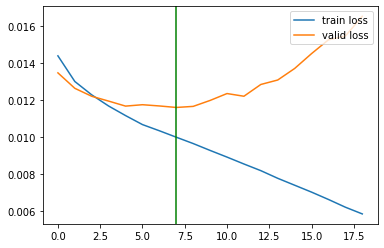

In [78]:
import matplotlib.pyplot as plt

plt.figure()
# plt.xticks(range(0, 10))
plt.plot(all_train_losses)
plt.plot(all_valid_losses)
plt.axvline(x=best_epoch, color='green')

plt.legend(['train loss', 'valid loss'], loc='upper right')
plt.show()

In [78]:
len(test_data)

15606

In [79]:
print(f'Best epoch: {best_epoch+1:02}')

Best epoch: 08


## Test the Model

In [80]:
model.load_state_dict(torch.load(saved_models_path + MODEL_SAVE_FILE))

test_loss, test_acc = evaluate(model, test_iterator, criterion, len(test_data))

print(f'Test Loss: {test_loss:.5f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.01165 | Test Acc: 69.35%


### Reevaluate on valid set

In [81]:
model.load_state_dict(torch.load(saved_models_path + MODEL_SAVE_FILE))

valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, len(valid_data))

print(f'Test Loss: {valid_loss:.5f} | Test Acc: {valid_acc*100:.2f}%')

Test Loss: 0.01161 | Test Acc: 70.15%


## Test on Kaggle Dataset and create submittion file

In [82]:
# Change the model target file
MODEL_SAVE_FILE_TARGET = 'LSTM_with_attention_embedding_in_model_origin-train-73.20-valid-70.15.pt'

def predict_kaggle_test(model, iterator):
    
    result = []
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths)
            
            predictions = predictions.argmax(1)
            
            for i in range(len(batch)):
                result.append([batch.id[0][i].item(), [batch.phrase_id[0][i].item(), predictions[i].item()]] )
    
    result.sort(key = lambda val: val[0])
        
    return result

In [83]:
model.load_state_dict(torch.load(saved_models_path + MODEL_SAVE_FILE_TARGET))

kaggle_result_list = predict_kaggle_test(model, kaggle_test_iterator)

kaggle_result_list[:10]

[[0, [156061, 3]],
 [1, [156062, 2]],
 [2, [156063, 2]],
 [3, [156064, 2]],
 [4, [156065, 2]],
 [5, [156066, 3]],
 [6, [156067, 3]],
 [7, [156068, 2]],
 [8, [156069, 3]],
 [9, [156070, 2]]]

In [84]:
kaggle_result_list[-10:]

[[66282, [222343, 2]],
 [66283, [222344, 2]],
 [66284, [222345, 2]],
 [66285, [222346, 2]],
 [66286, [222347, 2]],
 [66287, [222348, 0]],
 [66288, [222349, 1]],
 [66289, [222350, 1]],
 [66290, [222351, 1]],
 [66291, [222352, 1]]]

In [85]:
len(kaggle_result_list)

66292

In [86]:
loaded_kaggle_test.head(10)

,PhraseId,SentenceId,Phrase,Phrase_length,Tokenized_phrase,Indexed_phrase
0,156061,8545,An intermittently pleasing but mostly routine ...,188,"[xxbos, xxmaj, an, intermittently, pleasing, b...","[2, 7, 26, 2606, 1723, 30, 632, 1041, 409, 15, 3]"
1,156062,8545,An intermittently pleasing but mostly routine ...,77,"[xxbos, xxmaj, an, intermittently, pleasing, b...","[2, 7, 26, 2606, 1723, 30, 632, 1041, 409, 3]"
2,156063,8545,An,8,"[xxbos, xxmaj, an, xxeos]","[2, 7, 26, 3]"
3,156064,8545,intermittently pleasing but mostly routine effort,1,"[xxbos, intermittently, pleasing, but, mostly,...","[2, 2606, 1723, 30, 632, 1041, 409, 3]"
4,156065,8545,intermittently pleasing but mostly routine,6,"[xxbos, intermittently, pleasing, but, mostly,...","[2, 2606, 1723, 30, 632, 1041, 3]"
5,156066,8545,intermittently pleasing but,68,"[xxbos, intermittently, pleasing, but, xxeos]","[2, 2606, 1723, 30, 3]"
6,156067,8545,intermittently pleasing,2,"[xxbos, intermittently, pleasing, xxeos]","[2, 2606, 1723, 3]"
7,156068,8545,intermittently,65,"[xxbos, intermittently, xxeos]","[2, 2606, 3]"
8,156069,8545,pleasing,9,"[xxbos, pleasing, xxeos]","[2, 1723, 3]"
9,156070,8545,but,55,"[xxbos, but, xxeos]","[2, 30, 3]"


In [87]:
CSV_EXTENSION = '.submit.csv'

import csv

with open(saved_models_path + MODEL_SAVE_FILE_TARGET + CSV_EXTENSION, mode='w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    csv_writer.writerow(['PhraseId', 'Sentiment'])
    
    for i in range(len(kaggle_result_list)):
        csv_writer.writerow(kaggle_result_list[i][1])